# ニューラルネットワーク

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## MNISTデータセット

In [2]:
# MNIST 読み込み
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
print(X_train.shape)
print(X_test.shape)
print(X_train[0].dtype)
# print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)
uint8


In [4]:
# 平滑化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

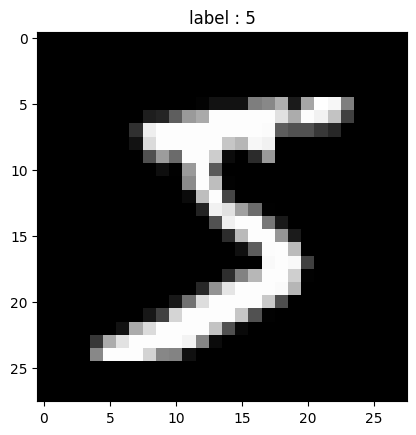

In [5]:
# 可視化
index = 0
image = X_train[index].reshape(28,28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

#### 前処理

In [6]:
# 0～1のfloat型に変換
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max())
print(X_train.min())

C:\Users\ryoga_inaba\AppData\Local\Temp\ipykernel_2364\2179964665.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train = X_train.astype(np.float)
C:\Users\ryoga_inaba\AppData\Local\Temp\ipykernel_2364\2179964665.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test = X_test.astype(np.float)


1.0
0.0


In [7]:
# 訓練データと検証データに分割
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print(X_train.shape)
print(X_val.shape)

(48000, 784)
(12000, 784)


In [8]:
# one-hot表現に変換
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_val_one_hot = enc.transform(y_val[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

y_train_one_hot.shape, y_val_one_hot.shape, y_test_one_hot.shape

C:\Users\ryoga_inaba\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((48000, 10), (12000, 10), (10000, 10))

## ニューラルネットワーク スクラッチ

### 【問題1】～【問題5】

In [9]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """
    
    def __init__(self, batch_size=20, n_features=784, n_nodes1=400, n_nodes2=200, n_output=10, sigma=0.02, lr=0.01, epoch=10, verbose=True):
        self.verbose = verbose
        self.batch_size = batch_size
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2 
        self.n_output = n_output
        self.sigma = sigma
        self.lr = lr
        self.epoch = epoch
        self.loss_train = []
        self.loss_val = []
        
        # 重みの初期化
        self.W1 = self.sigma * np.random.randn(self.n_features, self.n_nodes1)
        self.W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        self.W3 = self.sigma * np.random.randn(self.n_nodes2, self.n_output)
        self.B1 = self.sigma * np.random.randn(1, self.n_nodes1)
        self.B2 = self.sigma * np.random.randn(1, self.n_nodes2)
        self.B3 = self.sigma * np.random.randn(1, self.n_output)

    def tanh_function(self, X):
        return np.tanh(X)
    
    def softmax(self, X):
        return np.exp(X) / np.sum(np.exp(X), axis=1, keepdims=True)
    
    def cross_entropy_error(self, y, Z):
        return - np.sum(y * np.log(Z + 1e-7)) / len(y)
        
    def forward(self, X):
        self.A1 = X @ self.W1 + self.B1
        self.Z1 = self.tanh_function(self.A1)
        self.A2 = self.Z1 @ self.W2 + self.B2
        self.Z2 = self.tanh_function(self.A2)
        self.A3 = self.Z2 @ self.W3 + self.B3
        self.Z3 = self.softmax(self.A3)
        
    def backward(self, X, y):
        dA3 = (self.Z3 - y) / self.batch_size
        dW3 = self.Z2.T @ dA3
        dB3 = np.sum(dA3, axis=0)
        dZ2 = dA3 @ self.W3.T
        dA2 = dZ2 * (1 - self.tanh_function(self.A2)**2)
        dW2 = self.Z1.T @ dA2
        dB2 = np.sum(dA2, axis=0)
        dZ1 = dA2 @ self.W2.T
        dA1 = dZ1 * (1 - self.tanh_function(self.A1)**2)
        dW1 = X.T @ dA1
        dB1 = np.sum(dA1, axis=0)
        self.W3 -= self.lr * dW3
        self.B3 -= self.lr * dB3
        self.W2 -= self.lr * dW2
        self.B2 -= self.lr * dB2
        self.W1 -= self.lr * dW1
        self.B1 -= self.lr * dB1
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        
        for _ in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            for mini_X_train, mini_y_train in get_mini_batch:
                self.forward(mini_X_train)
                self.backward(mini_X_train, mini_y_train)
            self.forward(X)
            self.loss_train.append(self.cross_entropy_error(y, self.Z3))
            if X_val is not None:
                self.forward(X_val)
                self.loss_val.append(self.cross_entropy_error(y_val, self.Z3))
        if self.verbose:
            if X_val is None:
                print(self.loss_train)
            else:
                print(self.loss_train, self.loss_val)

    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """

        self.forward(X)
        return np.argmax(self.Z3, axis=1)


In [10]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    
    def __init__(self, X, y, batch_size=20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int32) # イテレーション回数

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]


### 【問題6】学習と推定

In [11]:
# 学習
nn = ScratchSimpleNeuralNetrowkClassifier(epoch=25)
nn.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

[0.4357117768938198, 0.334125888425195, 0.29763130346253547, 0.27402013833227, 0.25548123014926927, 0.23877418867765204, 0.22261632982459217, 0.20683256546919976, 0.19177876086402493, 0.17791521624778026, 0.16548146700130173, 0.15443208596635263, 0.14458040999764668, 0.1357263847147895, 0.127702186890435, 0.12037568977077712, 0.11364396609569337, 0.10742654014104065, 0.1016596844367517, 0.09629224464887415, 0.0912828784747764, 0.08659794547978959, 0.0822095441229642, 0.07809376055900678, 0.07422941455980393] [0.4509186798947232, 0.3535043075573386, 0.3185991125587527, 0.2968092471258202, 0.28005515576344103, 0.2648785534916111, 0.2499443343573915, 0.23511344903099238, 0.22082684370239913, 0.20763463022274428, 0.19583228373678335, 0.18539909964335496, 0.17616437993766695, 0.16794255078796072, 0.1605793504768442, 0.15395500517874317, 0.14797646533335937, 0.14256985437271238, 0.1376746543886993, 0.13323939224772413, 0.12921877003155985, 0.12557201699867573, 0.12226205551624045, 0.11925511

In [12]:
from sklearn.metrics import accuracy_score

y_pred = nn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9685


### 【問題7】学習曲線のプロット

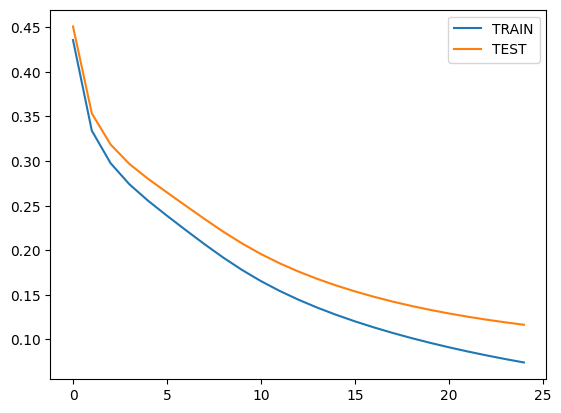

In [13]:
plt.plot(range(nn.epoch), nn.loss_train, label='TRAIN')
plt.plot(range(nn.epoch), nn.loss_val, label='TEST')
plt.legend()
plt.show()

### 【問題8】（アドバンス課題）誤分類の確認

C:\Users\ryoga_inaba\AppData\Local\Temp\ipykernel_2364\695618035.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  false_list = np.where(true_false == False)[0].astype(np.int) # 誤分類のインデックス


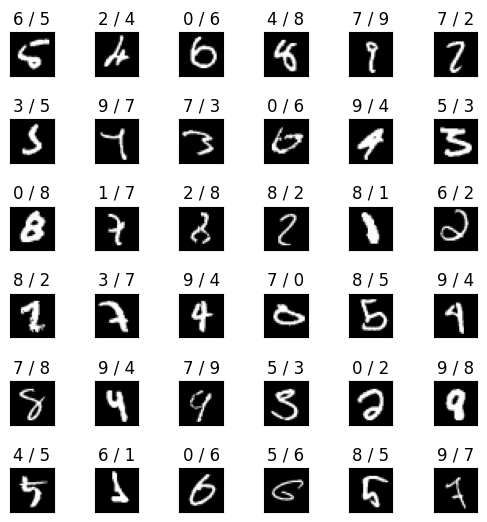

In [14]:
def misclassification(X_val, y_val, y_pred):
    """
    誤分類結果を並べて表示する。画像の上の表示は「推定結果/正解」である。

    Parameters:
    ----------
    y_pred : 推定値のndarray (n_samples,)
    y_val : 検証データの正解ラベル(n_samples,)
    X_val : 検証データの特徴量（n_samples, n_features)
    """
    
    num = 36 # いくつ表示するか

    true_false = y_pred == y_val
    false_list = np.where(true_false == False)[0].astype(np.int) # 誤分類のインデックス

    if false_list.shape[0] < num:
        num = false_list.shape[0]
    fig = plt.figure(figsize=(6, 6))
    fig.subplots_adjust(left=0, right=0.8, bottom=0, top=0.8, hspace=1, wspace=0.5)
    for i in range(num):
        ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
        ax.set_title("{} / {}".format(y_pred[false_list[i]], y_val[false_list[i]]))
        ax.imshow(X_val.reshape(-1,28,28)[false_list[i]], cmap='gray')

misclassification(X_test, y_test, y_pred)